# Unsupervised Clustering

## Introduction

`sklearn-raster` can be used to generate predictions from raster data using `scikit-learn` estimators, including unsupervised clusterers. In this tutorial, we'll load an RGB satellite image, train a k-means clusterer from sampled pixels, and predict cluster labels for each pixel in the image.

Before continuing, make sure you have the required packages installed with:

```
pip install sklearn-raster[tutorials]
```

## Load Data

We'll use `rioxarray` to load a [cloud-optimized GeoTIFF](https://developers.planet.com/docs/planetschool/an-introduction-to-cloud-optimized-geotiffs-cogs-part-1-overview/) of Sentinel-2 true color RGB imagery from [AWS](https://registry.opendata.aws/sentinel-2/).

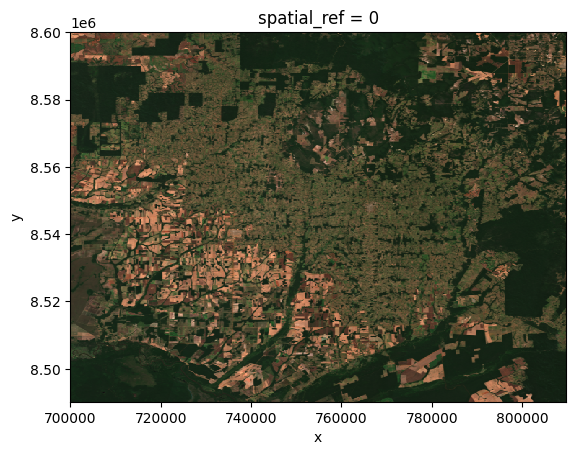

In [1]:
import rioxarray

ds = rioxarray.open_rasterio(
    "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/20/L/QL/2025/7/S2B_20LQL_20250725_0_L2A/TCI.tif",
    overview_level=3,
    band_as_variable=True,
).rename_vars({f"band_{i}": b for i, b in enumerate("RGB", start=1)})
ds.to_dataarray().plot.imshow()

## Extract Samples

Next, we'll extract a dataframe of sampled pixels for training the clusterer. Each pixel will have three features indicating red, green, and blue values.

In [2]:
X = (
    ds.to_dataframe()
    .dropna()
    .sample(n=1000, random_state=0)
    .reset_index()
    .loc[:, ["R", "G", "B"]]
)

X.head()

,R,G,B
0,85,74,50
1,43,48,28
2,68,70,42
3,76,62,42
4,82,77,48


Now we'll create a [`FeatureArrayEstimator`](../../api/wrap/#sklearn_raster.estimator.FeatureArrayEstimator) by wrapping a `scikit-learn` model. A wrapped estimator can be used like any other `sklearn` model by fitting and predicting with arrays or dataframes, but also supports predicting with raster data stored in `xarray` objects.

Fit the spatial estimator with the pixels we just sampled to prepare for clustering.

In [3]:
from sklearn.cluster import KMeans

from sklearn_raster import wrap

est = wrap(KMeans(n_clusters=3))
est.fit(X)

FeatureArrayEstimator(wrapped_estimator=KMeans(n_clusters=3))

## Predict Clusters

Finally, we can use the fit spatial estimator to predict cluster labels for each pixel in the raster dataset, returning a new raster output that preserves the input projection and mask.

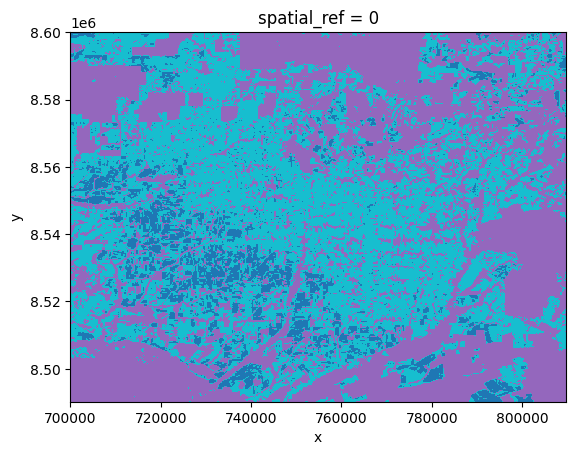

In [4]:
clusters = est.predict(ds, nodata_input=None)
clusters["target0"].plot.imshow(cmap="tab10_r", add_colorbar=False)